In [ ]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

In [ ]:
pip install --upgrade pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.5)


In [ ]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data
# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return
# -----------------------------------------------
""" Models """
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

**Monday's code goes here**

1) Load data

In [ ]:
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

# The timestep delta does not seem to be exactly 300 s.
# Let's introduce a timestep variable
timestep_dict = { i : v for v,i in enumerate(sorted(np.unique(train['Time [s]'])))}
train['t'] = train.apply(lambda t: timestep_dict[t['Time [s]']], axis=1)

2) Create an exploratory visualization of the data

In [ ]:
# Correlation matrix
train.corr().style.background_gradient(cmap='RdBu_r')

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),t
Time [s],1.000000,-0.468992,-0.603451,0.173113,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,1.000000
Precursor [ug/m3],-0.468992,1.000000,0.187737,-0.321693,0.007793,0.001164,-0.004638,-0.004627,-0.002819,-0.186997,-0.468992
Gas [ug/m3],-0.603451,0.187737,1.000000,-0.273293,-0.034824,0.218385,-0.191867,0.160175,-0.007839,-0.274615,-0.603451
Aerosol [ug_m3],0.173113,-0.321693,-0.273293,1.000000,-0.583094,0.155142,0.440273,0.055472,-0.024434,0.173642,0.173113
temperature (K),0.000000,0.007793,-0.034824,-0.583094,1.000000,-0.044443,0.029688,-0.026867,0.006618,-0.043906,0.000000
solar zenith angle (degree),-0.000000,0.001164,0.218385,0.155142,-0.044443,1.000000,-0.010855,0.032339,0.003128,-0.004629,0.000000
pre-existing aerosols (ug/m3),-0.000000,-0.004638,-0.191867,0.440273,0.029688,-0.010855,1.000000,0.012338,0.020699,0.020966,0.000000
o3 (ppb),0.000000,-0.004627,0.160175,0.055472,-0.026867,0.032339,0.012338,1.000000,-0.007294,0.014054,0.000000
nox (ppb),0.000000,-0.002819,-0.007839,-0.024434,0.006618,0.003128,0.020699,-0.007294,1.000000,0.011001,-0.000000
oh (10^6 molec/cm3),-0.000000,-0.186997,-0.274615,0.173642,-0.043906,-0.004629,0.020966,0.014054,0.011001,1.000000,0.000000


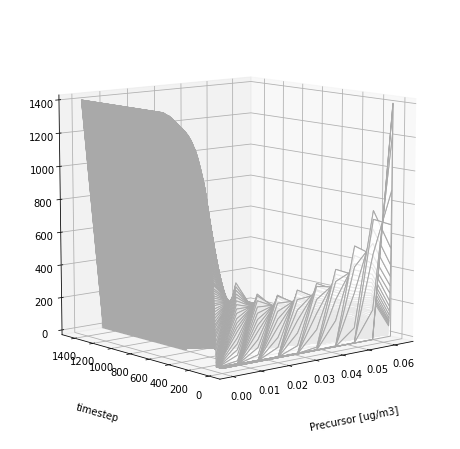

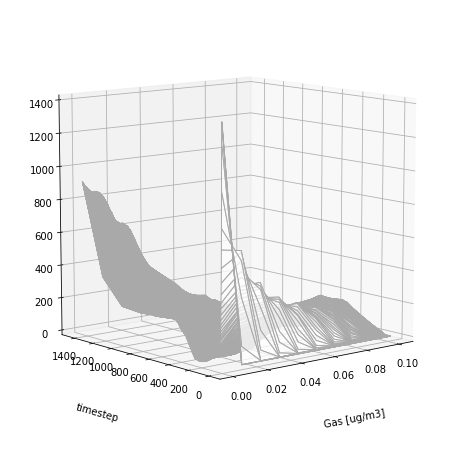

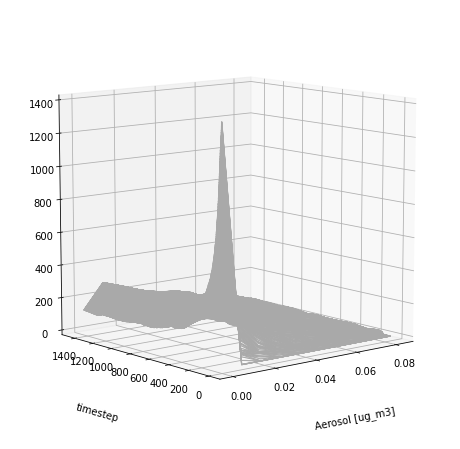

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
def hist_laxis(data, n_bins, range_limits):
    # Setup bins and determine the bin location for each element for the bins
    R = range_limits
    N = data.shape[-1]
    bins = np.linspace(R[0],R[1],n_bins+1)
    data2D = data.reshape(-1,N)
    idx = np.searchsorted(bins, data2D,'right')-1

    # Some elements would be off limits, so get a mask for those
    bad_mask = (idx==-1) | (idx==n_bins)

    # We need to use bincount to get bin based counts. To have unique IDs for
    # each row and not get confused by the ones from other rows, we need to 
    # offset each row by a scale (using row length for this).
    scaled_idx = n_bins*np.arange(data2D.shape[0])[:,None] + idx

    # Set the bad ones to be last possible index+1 : n_bins*data2D.shape[0]
    limit = n_bins*data2D.shape[0]
    scaled_idx[bad_mask] = limit

    # Get the counts and reshape to multi-dim
    counts = np.bincount(scaled_idx.ravel(),minlength=limit+1)[:-1]
    counts.shape = data.shape[:-1] + (n_bins,)
    return counts, bins

# Have a look at the initial conditions and the distribution of the quantities
# basically only a 3D-version of the first figure of this notebook

quantities = ['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']
for quantity in quantities:
    fig, ax1 = plt.subplots(figsize=(8,8))
    y=np.arange(train.t.max()+1)
    z = train.sort_values('t')[quantity].values.reshape(train.t.max()+1,len(train.id.unique()))
    Z, bins = hist_laxis(z, 10, [np.nanmin(z), np.nanmax(z)])
    x = bins[:-1]
    
    X, Y = np.meshgrid(x, y)
    ax1 = plt.subplot(projection='3d')
    
    ax1.view_init(10,-130)
    ax1.set_xlabel(quantity,labelpad=25)
    ax1.set_ylabel('timestep', labelpad=25)

    surf = ax1.plot_surface(X, Y, Z, rstride=1, cstride=1000, color='white',
                            alpha=0.75, linewidth=1, shade=False, edgecolors='darkgrey')
    plt.show()

3) Test two different transformation and scaling methods

Epoch 1/5
7875/7875 [==============================] - 18s 2ms/step - loss: 0.0149 - val_loss: 0.0122
Epoch 2/5
7875/7875 [==============================] - 18s 2ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 3/5
7875/7875 [==============================] - 18s 2ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 4/5
7875/7875 [==============================] - 19s 2ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 5/5
7875/7875 [==============================] - 18s 2ms/step - loss: 0.0121 - val_loss: 0.0120
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_____________

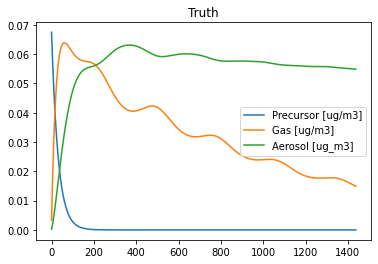

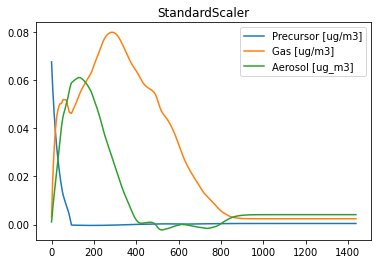

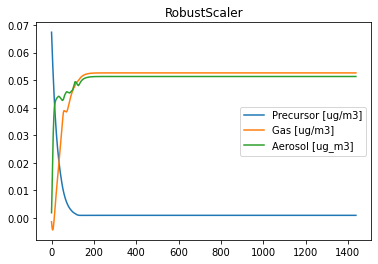

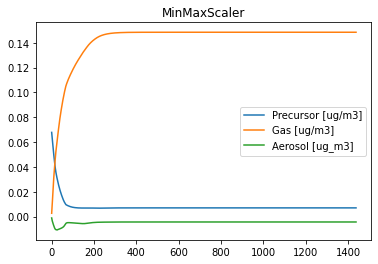

In [ ]:
test, train, val = map(fetch_data, gecko_files)

input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)

scaled_data = {}
for s, Scaler in enumerate([StandardScaler, RobustScaler, MinMaxScaler]):
    input_scaler = Scaler()
    output_scaler = Scaler()

    scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
    scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
    scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
    scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])
    
    tf.random.set_seed(seed)
    mod = dense_neural_net()
    history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                      batch_size=256, epochs=5, verbose=1)
    mod.summary()
    
    random.seed(seed)
    num_exps = 1
    pred_box, true_box = run_emulator_ensemble(val_in, mod, num_exps, input_vars, input_scaler, output_scaler)
    
    # get predictions and truth
    pred_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_val_in))).iloc[1:,:]
    true_val = val_out.iloc[:-1,1:4]
    
    print('Metrics for base model:')
    evaluate_mod(true_val, pred_nn)
    
    print('Metrics for Box Emulator:')
    evaluate_mod(true_box, pred_box)

    ## Quick plot to see if emulator is capturing the patterns
    if s ==0:
        true_box.iloc[:,0:3].plot(title='Truth')
    pred_box.iloc[:,0:3].plot(title=({0:'StandardScaler', 1:'RobustScaler', 2:'MinMaxScaler'}[s]))

4) Test one dimensionality reduction method

In [ ]:
# -----Re-load the data-----
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)
# -----Specified the inputs/outputs and training/validation dataset-----
input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)
# -----Iniailize the scaling scaler-----
# Standardization
input_scaler = StandardScaler()
output_scaler = StandardScaler()
# -----Data scaling-----
scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

In [ ]:
# -----Load in the necessary library-----
from sklearn.decomposition import PCA
# -----Import the PCA-----
pca = PCA(.95) # choose the minimum number if principal components such that 95% of varianve is retained
# -----Apply the PCA-----
pca.fit(scaled_train_in) # caution: fitting the PCA on the training dataset only
# -----Apply the mapping to both training and testing dataset
train_in_PCA = pca.transform(scaled_train_in)
test_in_PCA = pca.transform(scaled_val_in)
# ...then you can use the "train_in_PCA" to do any model fitting task

5) Train a linear model

In [28]:
# Note: "Ordinary least squares Linear Regression"
# -----Load in the necessary library-----
import numpy as np
from sklearn.linear_model import LinearRegression
L_reg = LinearRegression().fit(scaled_train_in,scaled_train_out)
# -----Get the prdictions and truth-----
random.seed(seed);
num_exps = 5;
pred_box, true_box = run_emulator_ensemble(val_in, L_reg, num_exps, input_vars, input_scaler, output_scaler);
# -----Get the prediction and truth-----
pred_nn = pd.DataFrame(output_scaler.inverse_transform(L_reg.predict(scaled_val_in))).iloc[1:,:];
true_val = val_out.iloc[:-1,1:4];
print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

Metrics for base model:
RMSE: Precursor: 0.00018, Gas: 0.00021, Aerosols: 0.00006
R2: Precursor: 0.99997, Gas: 0.99993, Aerosols: 0.99999
Hellenger Distance: Precursor: 0.00003, Gas: 0.00001, Aerosols: 0.00002


6) Train a decision tree ensemble method of your choice

In [ ]:
# -----Load in the necessary library-----
from sklearn.ensemble import RandomForestRegressor;
# -----Initialize the model-----
regressor = RandomForestRegressor(n_estimators=100,criterion='mse',max_depth=None,min_samples_split=100, min_samples_leaf=100,
min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,
min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True,
oob_score=False, n_jobs=None, random_state=None, verbose=1, warm_start=False,
ccp_alpha=0.0, max_samples=None);
# -----Train the model-----
RF=regressor.fit(scaled_train_in,scaled_train_out);
# -----Get the prdictions and truth-----
random.seed(seed);
num_exps = 5;
pred_box, true_box = run_emulator_ensemble(val_in, RF, num_exps, input_vars, input_scaler, output_scaler);
# -----Get the prediction and truth-----
pred_nn = pd.DataFrame(output_scaler.inverse_transform(RF.predict(scaled_val_in))).iloc[1:,:];
true_val = val_out.iloc[:-1,1:4];
print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

Streaming output truncated to the last 5000 lines.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend Sequent

Metrics for base model:
RMSE: Precursor: 0.00031, Gas: 0.00043, Aerosols: 0.00038
R2: Precursor: 0.99937, Gas: 0.99968, Aerosols: 0.99970
Hellenger Distance: Precursor: 0.00030, Gas: 0.00028, Aerosols: 0.00030


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished


### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

**Tuesday's code goes here**

1) Train a densely connected neural network

2) Train a convolutional or recurrent neural network (depends on problem)

3) Experiment with different architectures

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

**Wednesday's code goes here**

1) Calculate three relevant evaluation metrics for each ML solution and baseline

2) Refine machine learning approaches and test additional hyperparameter settings

### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

**Thursday's code goes here**

1) Evaluate two interpretation methods for your machine learning solution

2) Compare interpretation of baseline with your approach

3) Submit best results on project to leaderboard

4) Prepare 2 Google Slides on team's approach and submit them

## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.